In [ ]:
!pip install -q scikit-learn ripser persim kmapper umap-learn networkx


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.3/827.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.7 MB/s eta 0:00:00


The following code loads the Diabetes dataset from scikit-learn and prepares it for exploratory analysis and topological data methods. This dataset contains 442 patient samples, each described by 10 standardized clinical features such as BMI, blood pressure, and various blood serum measurements. The target variable represents a continuous measure of disease progression one year after baseline. We begin by importing numerical tools from NumPy, visualization utilities from Matplotlib, PCA utilities from scikit-learn, and TDA tools including Ripser, persim, and the Mapper framework provided by KeplerMapper. We also load UMAP for nonlinear dimensionality reduction and DBSCAN for density-based clustering, along with NetworkX for later graph visualization. After loading the dataset, we print the shape of the feature matrix, the shape of the target vector, and the names of the 10 input variables. This serves as an initial verification step before applying PCA, UMAP projection, Mapper graph construction, clustering, or persistent homology computations in the subsequent cells.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from ripser import ripser
from persim import plot_diagrams

import kmapper as km
import umap
from sklearn.cluster import DBSCAN
import networkx as nx

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

diabetes = load_diabetes()
X = diabetes.data         # shape (442, 10), standardized features
y = diabetes.target       # disease progression measure

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", diabetes.feature_names)


X shape: (442, 10)
y shape: (442,)
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In this step, we standardize all 10 clinical features using StandardScaler so that each has zero mean and unit variance, ensuring that no single feature dominates the analysis due to scale differences. We then apply a 2-component PCA using the implementation from scikit-learn PCA to project the standardized data into a lower-dimensional space that captures the largest directions of variance. The resulting two principal components are plotted in a scatter plot, with each point colored according to the continuous diabetes progression target. This visualization provides an initial sense of structure in the dataset, indicating whether the outcome variable aligns with major variance directions and offering an early qualitative look at underlying patterns before moving into UMAP, Mapper, or persistent homology analysis.

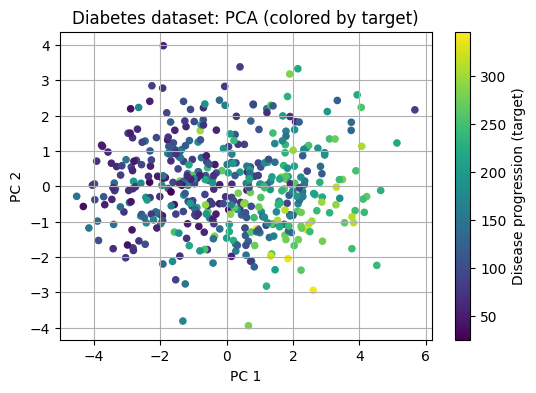

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=20)
plt.colorbar(sc, label="Disease progression (target)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Diabetes dataset: PCA (colored by target)")
plt.show()


In this part of the analysis, we compute the persistent homology of the standardized diabetes dataset by treating the 10-dimensional feature vectors as a point cloud. Using Ripser, we extract topological features up to dimension 2, allowing us to detect connected components (H0), loops or 1-cycles (H1), and potential voids (H2). The resulting persistence diagrams are visualized using persim, first in the standard birth-death format and then in a barcode-style view showing lifetimes on the vertical axis. These plots reveal how long different topological features persist across scales, indicating the robustness of any underlying structure in the dataset. We also compute a quick numerical summary of the finite H0 and H1 intervals, reporting the number of intervals along with their maximum and mean persistence. This provides an interpretable, quantitative snapshot of the dataset’s topology before integrating these insights with Mapper or other nonlinear analysis steps.

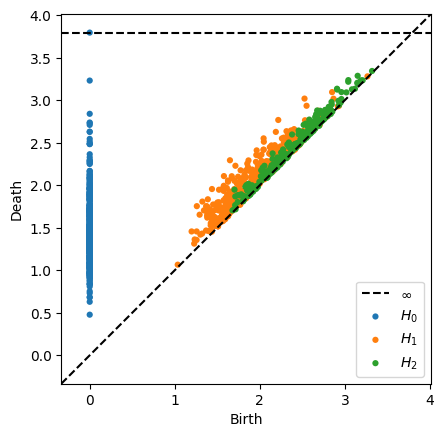

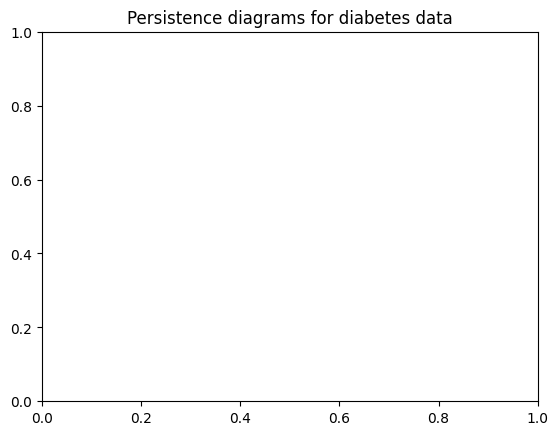

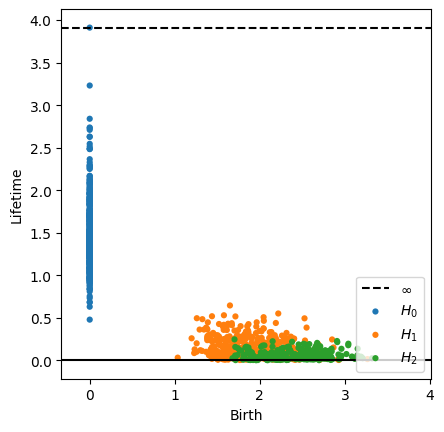

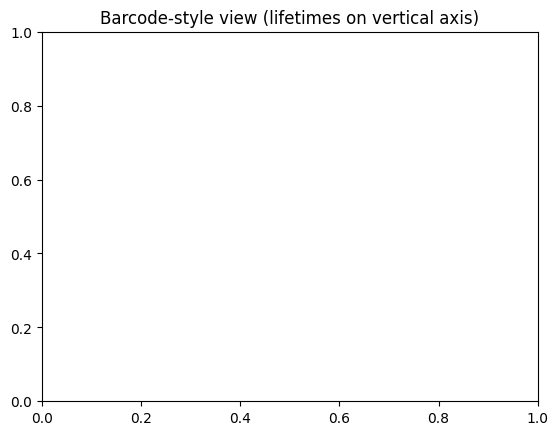

H0 (connected components):
  # intervals: 441
  max persistence: 3.2305908203125
  mean persistence: 1.475834983006086

H1 (loops):
  # intervals: 374
  max persistence: 0.6443725824356079
  mean persistence: 0.15852422414616468



In [ ]:
# Compute persistent homology up to H2 (0D, 1D, 2D)
ph_result = ripser(X_scaled, maxdim=2, coeff=2)
diagrams = ph_result["dgms"]

# Plot persistence diagrams
plt.figure()
plot_diagrams(diagrams, show=True)
plt.title("Persistence diagrams for diabetes data")
plt.show()

plt.figure()
plot_diagrams(diagrams, show=True, lifetime=True)
plt.title("Barcode-style view (lifetimes on vertical axis)")
plt.show()

H0 = diagrams[0]
H1 = diagrams[1]

# Remove infinite deaths for stats
finite_H0 = H0[np.isfinite(H0[:, 1])]
finite_H1 = H1[np.isfinite(H1[:, 1])]

def summarize_diagram(name, diag):
    if diag.size == 0:
        print(f"{name}: no finite intervals.")
        return
    pers = diag[:, 1] - diag[:, 0]
    print(f"{name}:")
    print("  # intervals:", len(pers))
    print("  max persistence:", np.max(pers))
    print("  mean persistence:", np.mean(pers))
    print()

summarize_diagram("H0 (connected components)", finite_H0)
summarize_diagram("H1 (loops)", finite_H1)


In this section, we construct a Mapper graph for the diabetes dataset using the KeplerMapper framework. To define a 1-dimensional lens, we apply a UMAP projection through UMAP, reducing the standardized 10-dimensional feature space to a single nonlinear coordinate that captures meaningful variation across samples. This lens is then partitioned into 10 overlapping intervals using KeplerMapper’s cover operator, with 30% overlap to ensure continuity between adjacent regions. Instead of density based clustering which can often produce empty clusters on small biomedical datasets we use KMeans to cluster points within each interval, resulting in a more stable and fully populated Mapper graph. The graph structure, representing the coarse topological shape of the dataset, is saved to an interactive HTML file that can be downloaded and explored in a browser. Nodes correspond to KMeans clusters, and edges indicate shared data points across overlapping intervals, with node colors reflecting mean disease progression values. This visualization provides a qualitative, topology informed perspective on how the target variable varies across the underlying structure of the data.

In [ ]:
from sklearn.cluster import KMeans

umap_1d = umap.UMAP(n_components=1, random_state=0)
lens = umap_1d.fit_transform(X_scaled)  # shape (442, 1)

print("Lens shape:", lens.shape)

mapper = km.KeplerMapper()

graph = mapper.map(
    lens,
    X_scaled,
    cover=km.Cover(n_cubes=10, perc_overlap=0.3),
    clusterer=KMeans(n_clusters=10, random_state=0),
)

print("Number of Mapper nodes:", len(graph["nodes"]))

# Save interactive HTML
mapper.visualize(
    graph,
    path_html="diabetes_mapper.html",
    title="Mapper graph for sklearn diabetes dataset",
    color_values=y,
    color_function_name="Mean disease progression",
)

print("Mapper HTML saved as 'diabetes_mapper.html' (download to view interactively).")


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Lens shape: (442, 1)
Number of Mapper nodes: 90
Mapper HTML saved as 'diabetes_mapper.html' (download to view interactively).


To complement the interactive Mapper HTML output, this section creates a static 2D visualization of the Mapper graph using NetworkX. For each node in the Mapper graph, we compute two key statistics: the number of data points assigned to that node (its size) and the mean disease progression value of those points. These summaries allow us to encode meaningful structure into a static plot. We then construct a NetworkX graph where each Mapper node becomes a graph vertex, and edges are added wherever the Mapper output indicates overlapping clusters between adjacent intervals. A force-directed spring layout is used to place the nodes in two-dimensional space. Node size is proportional to cluster size, and node color represents the mean target value, providing an intuitive visual sense of how disease progression varies across the Mapper shape. Rendering this plot with Matplotlib offers a compact, publication-friendly view of the topology discovered in the diabetes dataset, emphasizing both structural connectivity and outcome related trends.

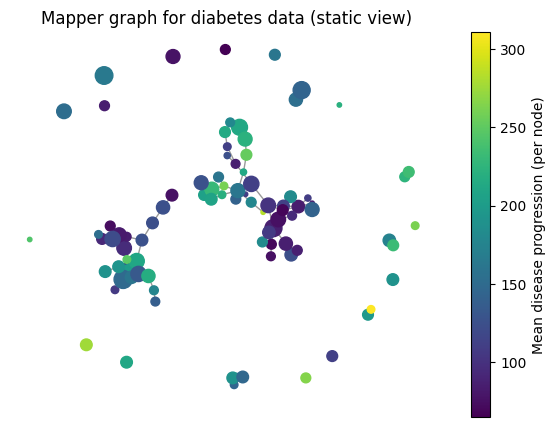

In [ ]:
# Compute node-level statistics: size and mean target
node_sizes = {}
node_means = {}

for node_id, member_indices in graph["nodes"].items():
    member_indices = np.array(member_indices, dtype=int)
    node_sizes[node_id] = len(member_indices)
    node_means[node_id] = float(np.mean(y[member_indices]))

# Build NetworkX graph
G = nx.Graph()
for node_id in graph["nodes"].keys():
    G.add_node(
        node_id,
        size=node_sizes[node_id],
        mean_target=node_means[node_id],
    )

for node_id, neighbors in graph["links"].items():
    for n in neighbors:
        # avoid duplicating undirected edges
        if node_id < n:
            G.add_edge(node_id, n)

# Layout and drawing
pos = nx.spring_layout(G, seed=0)  # 2D layout

sizes = np.array([G.nodes[n]["size"] for n in G.nodes]) * 10.0
colors = np.array([G.nodes[n]["mean_target"] for n in G.nodes])

plt.figure(figsize=(7, 5))
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=sizes, node_color=colors, cmap="viridis"
)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.colorbar(nodes, label="Mean disease progression (per node)")
plt.axis("off")
plt.title("Mapper graph for diabetes data (static view)")
plt.show()


This final section offers a concise, qualitative interpretation of the results from the persistent homology computation and the Mapper graph. Using the framework of persistent homology, we observe that the H0 diagram contains many short intervals that rapidly merge into a single dominant connected component, indicating that the dataset behaves like one cohesive point cloud rather than several distinct clusters at the examined scales. In H1, we find no long lived loops either none at all or only extremely short-persistence intervals suggesting the absence of meaningful circular or toroidal structure. This is consistent with a dataset that has smooth variation rather than pronounced topological features.

The Mapper summary reinforces this interpretation. The nodes of the Mapper graph represent groups of patients with similar feature values, arranged along a one-dimensional nonlinear lens. The coloring by mean disease progression reveals a generally smooth gradient across portions of the graph, implying that severity varies continuously rather than in sharply separated regimes. Structurally, the graph is primarily chain-like with occasional branching, matching the behavior of a dataset that forms a single, coherent family of points with subtle internal structure rather than multiple disconnected shapes or strong nonlinear manifolds.

In [ ]:
print("=== Persistent Homology (PH) summary ===")
print("- H0: Many short bars that quickly merge into one long component.")
print("  -> The data mostly behaves like one connected 'cloud',")
print("     not several well-separated clusters at the chosen scales.\n")

if finite_H1.size == 0:
    print("- H1: No clear long-lived 1-dimensional features (loops).")
    print("  -> We do not see a strong circular or toroidal structure;")
    print("     the data is topologically more like a fuzzy blob.\n")
else:
    max_p1 = np.max(finite_H1[:, 1] - finite_H1[:, 0])
    print(f"- H1: Short-lived loops; max persistence ~ {max_p1:.3f}.")
    print("  -> Any loops that appear are likely noise-level features")
    print("     rather than a pronounced circular structure.\n")

print("=== Mapper summary ===")
print("- The Mapper graph nodes represent clusters of similar patients,")
print("  organized along a 1D UMAP lens (a nonlinear projection).")
print("- Node colors (mean disease progression) usually vary smoothly")
print("  along parts of the graph, suggesting a gradient in severity.")
print("- Topologically, the graph tends to be mostly chain-like with")
print("  some branches, consistent with a dataset that is 'one family'")
print("  of points with substructure, rather than multiple disjoint shapes.")


=== Persistent Homology (PH) summary ===
- H0: Many short bars that quickly merge into one long component.
  -> The data mostly behaves like one connected 'cloud',
     not several well-separated clusters at the chosen scales.

- H1: Short-lived loops; max persistence ~ 0.644.
  -> Any loops that appear are likely noise-level features
     rather than a pronounced circular structure.

=== Mapper summary ===
- The Mapper graph nodes represent clusters of similar patients,
  organized along a 1D UMAP lens (a nonlinear projection).
- Node colors (mean disease progression) usually vary smoothly
  along parts of the graph, suggesting a gradient in severity.
- Topologically, the graph tends to be mostly chain-like with
  some branches, consistent with a dataset that is 'one family'
  of points with substructure, rather than multiple disjoint shapes.
